In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
# use tf datasets to download this features 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "PlantVillage",
            seed=123,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
print(len(dataset))
print(len(dataset)*BATCH_SIZE)

68
2176


(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]
(256, 256, 3)
1


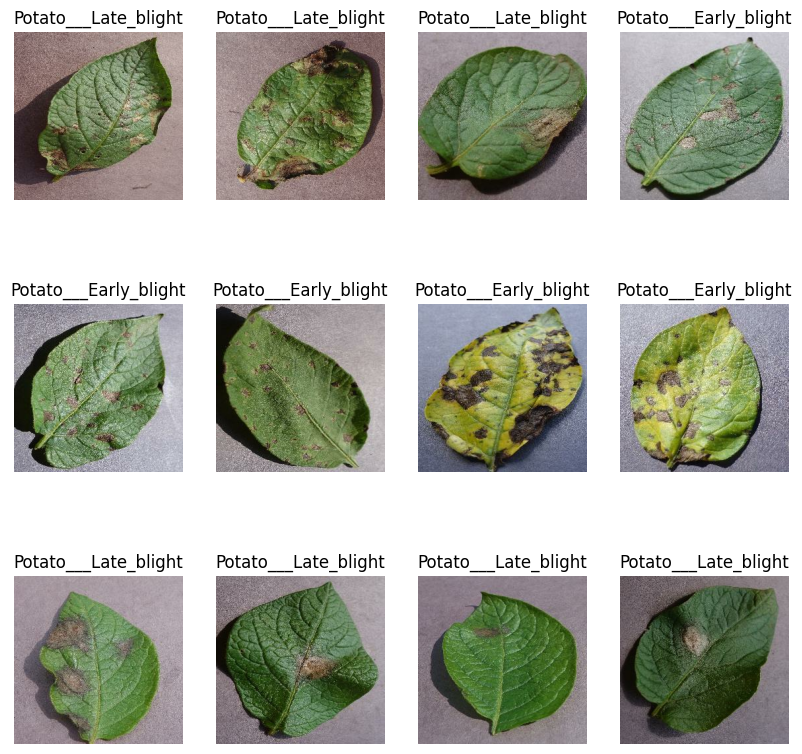

In [7]:
temp=0
for img, label in dataset.take(1):
    print(img.shape) # shape of img batch
    print(label.numpy()) # labels of 32 images
    img[0] # get tensor of first img
    print(img[0].shape) # shape of first img
    print(label[0].numpy()) # shape of first img
    img[0].numpy() # from tensor to numpy
    #viz 12 images 
    plt.figure(figsize=(10,10))
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_name[label[i].numpy()])
        plt.axis('off')


In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    '''
        80% training
        20% test and validation

    '''
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(
    len(train_ds),
    len(val_ds),
    len(test_ds)
)

54 6 8


In [10]:
# my training will run fast
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/50
54/54 [==============================] - 131s 2s/step - loss: 0.9080 - accuracy: 0.4809 - val_loss: 0.8671 - val_accuracy: 0.6198
Epoch 2/50
54/54 [==============================] - 119s 2s/step - loss: 0.8013 - accuracy: 0.5932 - val_loss: 0.5683 - val_accuracy: 0.7604
Epoch 3/50
54/54 [==============================] - 119s 2s/step - loss: 0.5603 - accuracy: 0.7546 - val_loss: 0.4270 - val_accuracy: 0.8073
Epoch 4/50
54/54 [==============================] - 119s 2s/step - loss: 0.3748 - accuracy: 0.8466 - val_loss: 0.3620 - val_accuracy: 0.8385
Epoch 5/50
54/54 [==============================] - 119s 2s/step - loss: 0.2767 - accuracy: 0.8814 - val_loss: 0.2818 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 119s 2s/step - loss: 0.2413 - accuracy: 0.8924 - val_loss: 0.1578 - val_accuracy: 0.9219
Epoch 7/50
54/54 [==============================] - 120s 2s/step - loss: 0.1825 - accuracy: 0.9236 - val_loss: 0.2389 - val_accuracy: 0.8958
Epoch 8/50
54

In [16]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 646ms/step - loss: 0.0428 - accuracy: 0.9922


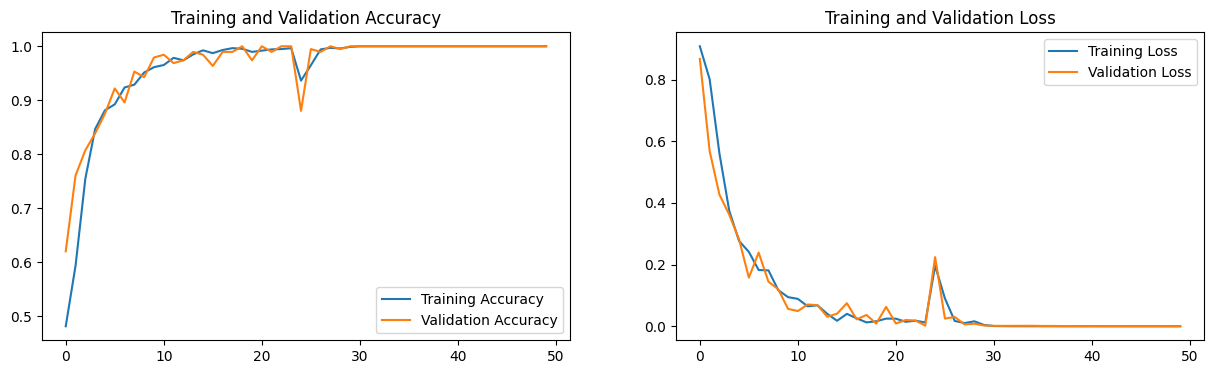

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

##

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

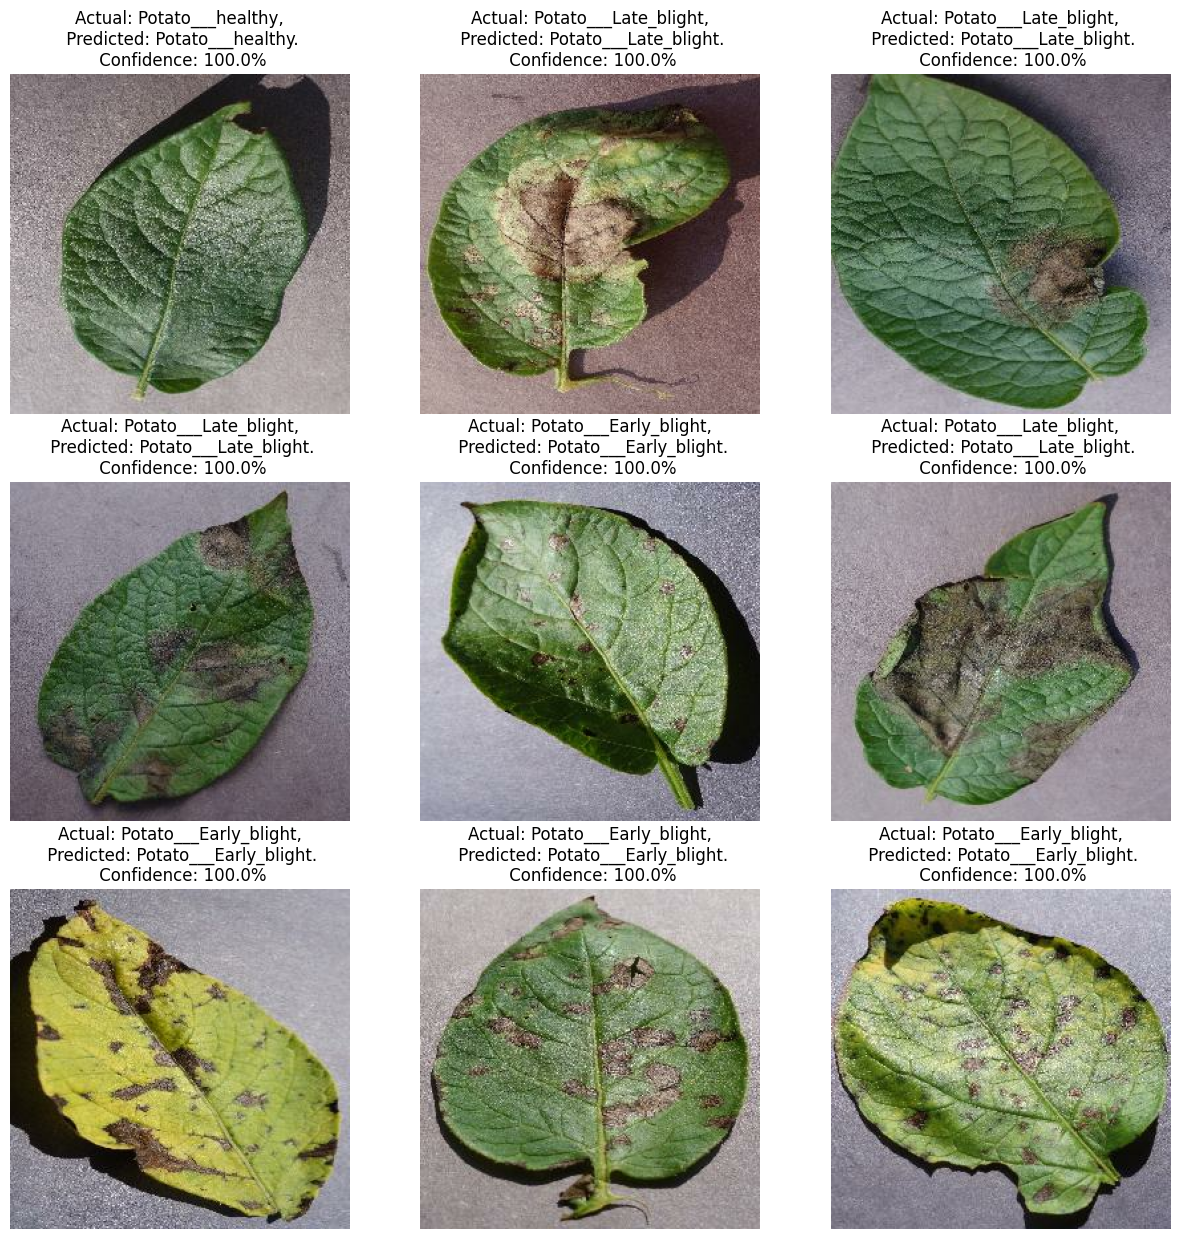

In [18]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [20]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets
